**StyleGAN2-ADA** (Karras et al., *NeurIPS 2020*) is an improved version of StyleGAN2 designed to maintain high-fidelity image synthesis when training data is limited. It extends the original StyleGAN2 architecture with **adaptive data augmentation (ADA)**, a dynamic regularization mechanism that prevents the discriminator from overfitting. This makes the model far more stable and data-efficient.


## Generative Adversarial Networks (GANs)

Generative Adversarial Networks (GANs) are among the most successful approaches to realistic image synthesis.  
They consist of two neural networks — a **Generator** $(G)$ and a **Discriminator** $(D)$ — trained in opposition:

- The **Generator** tries to produce synthetic samples that look indistinguishable from real ones.
- The **Discriminator** learns to classify samples as *real* or *fake*.

The training process can be formalized as a **minimax game**:

$$
\min_G \max_D \; 
\mathbb{E}_{x \sim p_\text{data}}[\log D(x)] 
+ \mathbb{E}_{z \sim p_z}[\log(1 - D(G(z)))]
$$

Here, the generator maps a random latent vector $z \sim \mathcal{N}(0, I)$ to an image that fools the discriminator.  
Both networks improve iteratively via gradient-based updates until equilibrium is reached.


## 1. StyleGAN

**StyleGAN** introduced a framework to separate *content* from *style*, enabling **intuitive manipulation** of generated images. Earlier GANs (e.g., DCGAN, Progressive GAN) could produce realistic images but often **lacked control** over semantic attributes such as pose, color, or texture.  
Additionally, the latent space $\mathcal{Z}$ was *entangled*: small perturbations in $z$ could alter multiple features simultaneously.


### 2. Generator Architecture

The generator $G$ can be conceptually decomposed as:

$$
G(z, c) = g(f(z), c)
$$

where $z \in \mathcal{Z}$ is a latent vector and $c$ represents class labels or conditioning (for conditional GANs).  

---

#### (a) Mapping Network $f: \mathcal{Z} \to \mathcal{W}$

The mapping network transforms the input latent $z$ into an intermediate latent code $w$:

$$
w = f(z) \in \mathcal{W}
$$

**Key points:**

- Input: $z \sim \mathcal{N}(0, I), \; z \in \mathbb{R}^{512}$  
- Output: $w \in \mathcal{W}$ (intermediate latent space)  
- Architecture: 8 fully connected layers with non-linearities  

The purpose of $f$ is to **disentangle latent factors**, producing a smoother latent space $\mathcal{W}$ than the original $\mathcal{Z}$.  

In $\mathcal{Z}$, small changes in a single component of $z$ often affect multiple image attributes simultaneously (entanglement).  
In $\mathcal{W}$, individual dimensions of $w$ correspond more cleanly to semantic features, enabling controlled manipulations.

---

#### (b) Synthesis Network $g(w, c)$

The synthesis network generates the image progressively, starting from a learned constant 4×4 feature map up to the target resolution (e.g., 1024×1024).  

Instead of feeding $z$ directly, each layer’s convolutional weights are modulated by $w$ (**style modulation**):

$$
W_l' = s_l \cdot W_l, \quad s_l = \text{Affine}(w)
$$

where:

- $W_l$ are the convolutional weights at layer $l$  
- $s_l$ are scaling coefficients obtained from an affine transformation of $w$  

This modulation allows **per-layer control of style**, such as texture, color, or pose.  

---

#### (c) Weight Demodulation

To prevent uneven channel magnitudes (which cause texture artifacts), **weight demodulation** is applied:

$$
W_l'' = \frac{W_l'}{\sqrt{\sum_j (W_{ij}')^2 + \epsilon}}
$$

This ensures all channels contribute evenly, improving stability and visual quality.

---

#### (d) Noise Injection

To add stochastic fine-grained details (like hair strands or skin pores), each layer receives a noise map:

$$
x_l' = y_l + b_l \cdot n_l, \quad n_l \sim \mathcal{N}(0, 1)
$$

where $b_l$ is a learned scalar controlling noise strength. This introduces variation independent of the style vector, enhancing realism.

---

#### (e) Feature Disentanglement in $\mathcal{W}$

Thanks to the mapping network and style modulation:

$$
\text{small change in } w_i \implies \text{specific change in generated image}
$$

This **disentangled latent space** enables **latent arithmetic**, for example:

$$
w_{\text{man with glasses}} - w_{\text{man without glasses}} + w_{\text{woman}} \approx w_{\text{woman with glasses}}
$$

By combining vectors in $\mathcal{W}$, we can manipulate attributes like **glasses, hair, gender, or pose** in a controlled manner.

## 5. Discriminator Design

The discriminator $D$ mirrors the generator but in reverse, reducing resolution via **residual downsampling blocks**.  
It outputs a scalar $D(x) \in [0,1]$ representing realness.

To prevent overfitting and stabilize gradients, **R1 regularization** is applied:

$$
R_1 = \frac{\gamma}{2} \, \mathbb{E}_{x \sim p_\text{data}} \Big[ \| \nabla_x D(x) \|_2^2 \Big]
$$

---

## 6. Adversarial Loss

Using the **non-saturating GAN loss**, the optimization objectives are:

\[
\begin{align}
L_D &= \mathbb{E}_{x \sim p_\text{data}}[\log D(x)] 
     + \mathbb{E}_{z \sim p_z}[\log(1 - D(G(z)))] + R_1 \\
L_G &= -\mathbb{E}_{z \sim p_z}[\log D(G(z))]
\end{align}
\]

- $L_D$: Discriminator tries to classify real/fake correctly
- $L_G$: Generator tries to maximize discriminator’s belief in fake images

---

## 7. Adaptive Discriminator Augmentation (ADA)

Limited datasets can lead to **discriminator overfitting**. ADA applies stochastic augmentations to both real and fake images with probability $p$:

$$
x' = T_p(x)
$$

where $T_p$ is a random augmentation pipeline.  
The system adjusts $p$ to maintain the discriminator’s real-image accuracy $a_r$ near a target $a_\text{target}$:

$$
p \leftarrow p + k \cdot (a_r - a_\text{target})
$$

- $k \approx 0.001$ (small update rate)
- $a_\text{target} \approx 0.6$  

This feedback loop prevents overfitting and allows **data-efficient training**.

---

## 8. Truncation Trick

To trade diversity for quality, latent codes can be truncated toward the mean $w_\text{avg}$:

$$
w' = w_\text{avg} + \psi (w - w_\text{avg})
$$

- $\psi \in [0,1]$ controls strength
- Smaller $\psi$: higher fidelity, lower diversity
- Larger $\psi$: more diversity, possible noise

---

## 9. Practical Training Details

- Latent spaces: $z, w \in \mathbb{R}^{512}$
- Resolutions: 256×256 → 1024×1024
- R1 regularization: $\gamma = 10$
- Optimizer: Adam $(\beta_1=0.0, \beta_2=0.99)$
- Batch size: 32–64 depending on GPU memory
- Augmentations: flips, color, cutouts, affine distortions

---

In [1]:
import torch
import sys
sys.path.append("/home/esra/stylegan2-ada-pytorch")  # adjust your path

import legacy
from pathlib import Path
import torch

torch.backends.cudnn.benchmark = False
torch.backends.cudnn.enabled = False
torch.cuda.empty_cache()
# Path to your checkpoint (Adjust your path) (Pretrained GAN model)
network_pkl = Path("/home/esra/stylegan2-ffhq-512x512.pkl")

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load the network
print(f"Loading network from: {network_pkl}")
with open(network_pkl, "rb") as f:
    G = legacy.load_network_pkl(f)['G_ema'].to(device)  # Load the generator

G.eval()
print("Generator loaded successfully!")

# Generate a random latent vector
z = torch.randn([1, G.z_dim], device=device)
label = torch.zeros([1, G.c_dim], device=device)  # for unconditional models

# Generate image
img = G(z, label, truncation_psi=0.7, noise_mode='const')
import torchvision.utils as vutils

# Rescale from [-1,1] to [0,1]
img01 = (img.clamp(-1, 1) + 1) / 2.0

# Save image
vutils.save_image(img01, "generated.png", normalize=False)
print("Image saved as generated.png")


Loading network from: /home/esra/stylegan2-ffhq-512x512.pkl
Generator loaded successfully!
Setting up PyTorch plugin "bias_act_plugin"... 

/home/esra/miniconda3/envs/ssl/lib/python3.9/site-packages/torch/utils/cpp_extension.py:2356: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... 

/home/esra/miniconda3/envs/ssl/lib/python3.9/site-packages/torch/utils/cpp_extension.py:2356: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


Done.
Image saved as generated.png


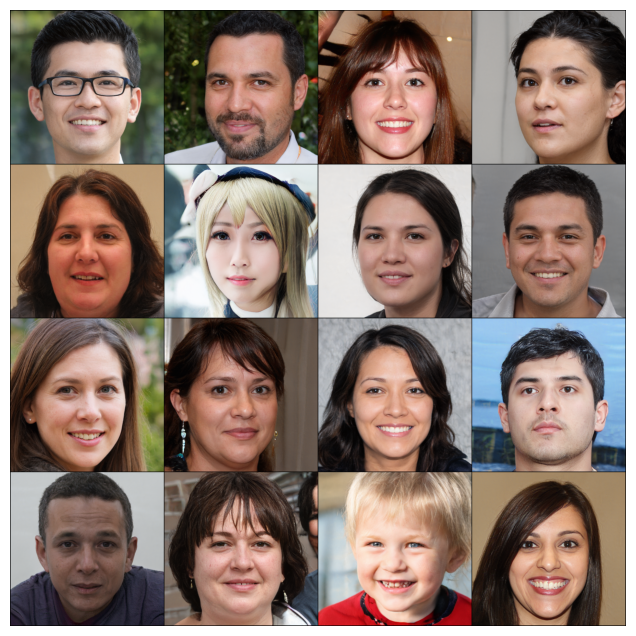

In [2]:
import torch
import torchvision.utils as vutils
import matplotlib.pyplot as plt

# --- Settings ---
num_images = 16           # total images to generate
grid_rows = 4             # rows in the displayed grid
device = "cuda" if torch.cuda.is_available() else "cpu"

# --- Generate random latent vectors ---
z = torch.randn([num_images, G.z_dim], device=device)
label = torch.zeros([num_images, G.c_dim], device=device)  # unconditional

# --- Generate images ---
with torch.no_grad():
    imgs = G(z, label, truncation_psi=0.7, noise_mode='const')  # [N,C,H,W]
    imgs = (imgs.clamp(-1, 1) + 1) / 2.0  # rescale to [0,1]

# --- Make grid ---
grid = vutils.make_grid(imgs, nrow=grid_rows, padding=2)

# --- Display in notebook ---
plt.figure(figsize=(8,8))
plt.axis('off')
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
plt.show()


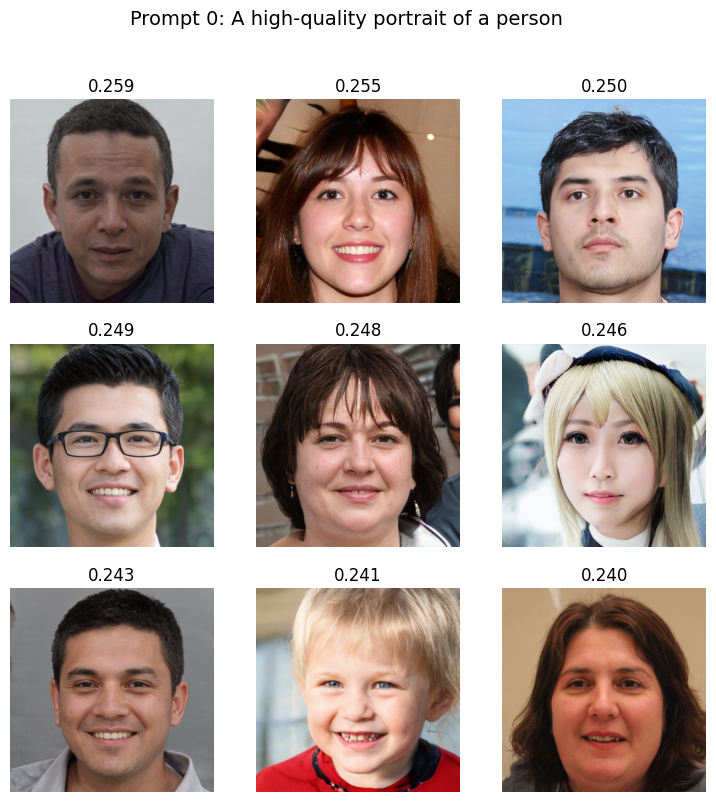

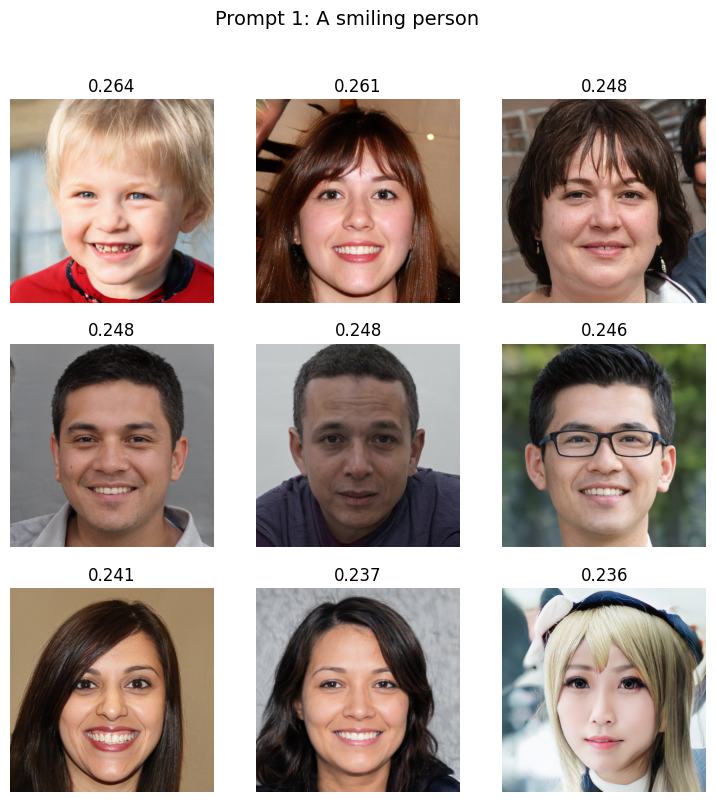

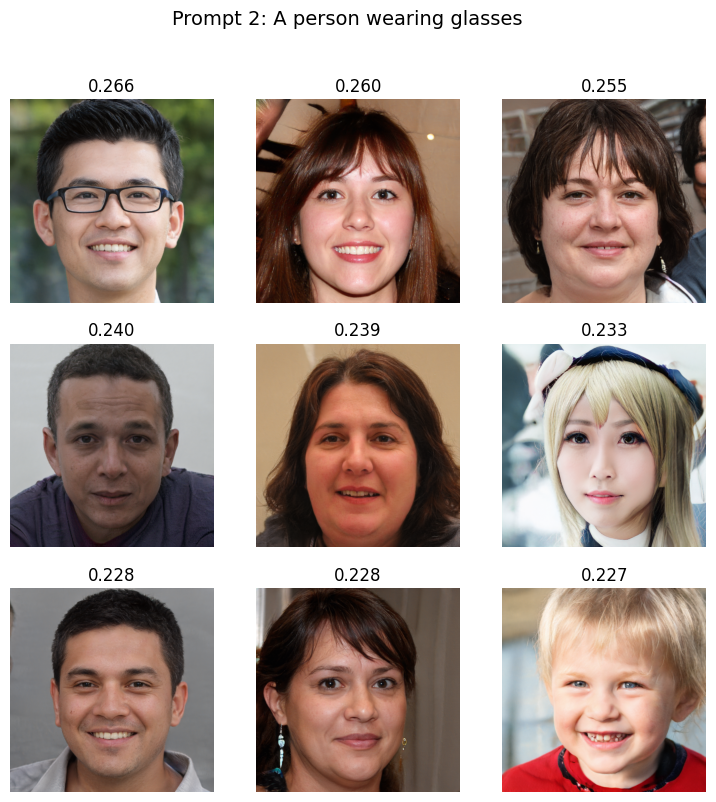

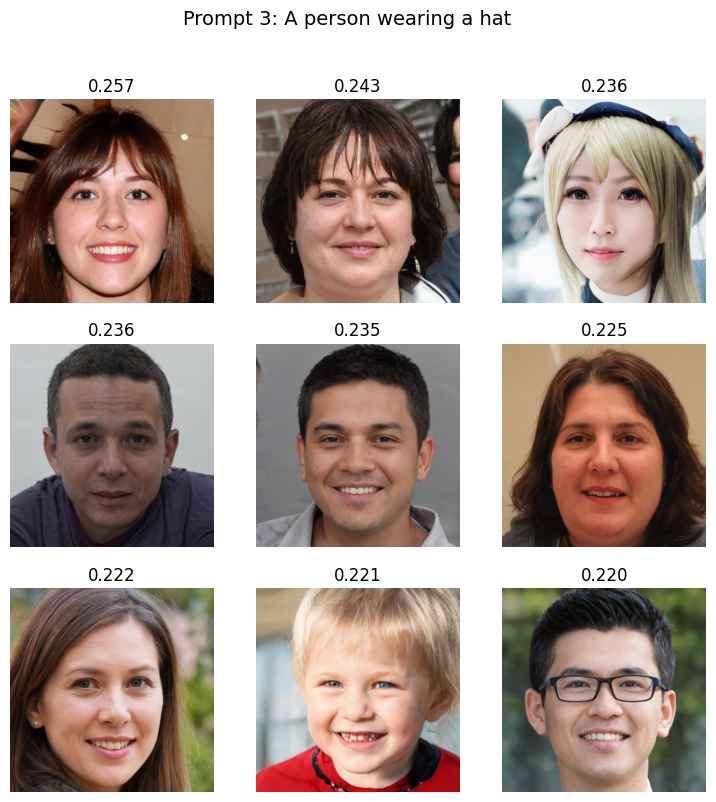

Top-5 for prompt 0 (index, score):
1 12 0.2593
2 2 0.2549
3 11 0.2496
4 0 0.2491
5 13 0.2483


In [3]:
# %%cell: CLIP scoring + display (drop this after your generation cell)
# If clip isn't installed, uncomment the next line and run once:
# !pip install git+https://github.com/openai/CLIP.git

import clip
from PIL import Image
import torch
import numpy as np
import os
import math
import torchvision.utils as vutils
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"

# ---- Load CLIP ----
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device, jit=False)
clip_model.eval()

def tensor_imgs_to_pil_list(imgs_tensor):
    # imgs_tensor: [N,C,H,W] float in [0,1] on CPU or GPU
    imgs_cpu = imgs_tensor.detach().cpu()
    arr = (imgs_cpu * 255).to(torch.uint8).numpy()  # [N,C,H,W] uint8
    pil_list = []
    for i in range(arr.shape[0]):
        img_np = arr[i].transpose(1, 2, 0)  # H W C
        pil_list.append(Image.fromarray(img_np))
    return pil_list

def encode_images_with_clip(pil_list, batch_size=32):
    feats = []
    for i in range(0, len(pil_list), batch_size):
        batch = pil_list[i:i+batch_size]
        batch_t = torch.cat([clip_preprocess(im).unsqueeze(0) for im in batch], dim=0).to(device)  # [B,3,224,224]
        with torch.no_grad():
            f = clip_model.encode_image(batch_t)
        feats.append(f)
        del batch_t; torch.cuda.empty_cache()
    feats = torch.cat(feats, dim=0)
    return feats  # [N, D], on device

def encode_text_with_clip(prompts):
    toks = clip.tokenize(prompts).to(device)
    with torch.no_grad():
        tfeats = clip_model.encode_text(toks)
    return tfeats  # [P, D], on device

def score_and_show(imgs, prompts, clip_img_batch=32, topk=9, save_topk=False, out_dir="./clip_topk"):
    """
    imgs: torch tensor [N,C,H,W] float in [0,1]
    prompts: list[str]
    """
    os.makedirs(out_dir, exist_ok=True)
    # Convert tensor -> list of PIL
    pil_list = tensor_imgs_to_pil_list(imgs)
    # Encode
    image_feats = encode_images_with_clip(pil_list, batch_size=clip_img_batch)  # [N,D] on device
    text_feats = encode_text_with_clip(prompts)  # [P,D] on device

    # Normalize and compute cosine similarity
    image_feats = image_feats / image_feats.norm(dim=-1, keepdim=True)
    text_feats = text_feats / text_feats.norm(dim=-1, keepdim=True)
    sim = (image_feats @ text_feats.T).cpu().numpy()   # [N, P]

    # For each prompt, sort images descending
    sorted_idx_per_prompt = [np.argsort(sim[:, j])[::-1] for j in range(sim.shape[1])]

    # Display top-K for each prompt
    for p_i, prompt in enumerate(prompts):
        idxs = sorted_idx_per_prompt[p_i][:topk]
        n = len(idxs)
        ncols = int(math.ceil(math.sqrt(n)))
        nrows = int(math.ceil(n / ncols))
        plt.figure(figsize=(3*ncols, 3*nrows))
        for i, idx in enumerate(idxs):
            plt.subplot(nrows, ncols, i+1)
            plt.imshow(pil_list[idx])
            plt.axis('off')
            # show score for this prompt and optionally a short preview of other scores
            other_scores = ", ".join([f"{sim[idx, j]:.2f}" for j in range(sim.shape[1])])
            plt.title(f"{sim[idx, p_i]:.3f}")
            if save_topk:
                # filename: promptIndex_rank_index_score.png
                safe_prompt = f"p{p_i}"
                fname = os.path.join(out_dir, f"{safe_prompt}_rank{i+1}_idx{idx}_s{sim[idx,p_i]:.4f}.png")
                pil_list[idx].save(fname)
        plt.suptitle(f"Prompt {p_i}: {prompt}", fontsize=14)
        plt.show()

    return sim, sorted_idx_per_prompt

# --------------------------
# Example usage using your 'imgs' tensor (which should be [N,C,H,W] in [0,1])
# If you used the earlier cells, 'imgs' already exists. If not, regenerate:
# num_images = 16
# z = torch.randn([num_images, G.z_dim], device=device)
# label = torch.zeros([num_images, G.c_dim], device=device)
# with torch.no_grad():
#     imgs = G(z, label, truncation_psi=0.7, noise_mode='const')
#     imgs = (imgs.clamp(-1,1)+1)/2.0

# Prompts to score against
prompts = [
    "A high-quality portrait of a person",
    "A smiling person",
    "A person wearing glasses",
    "A person wearing a hat"
]

# run scoring and display top-9 for each prompt
similarities, sorted_idx = score_and_show(imgs, prompts, clip_img_batch=16, topk=9, save_topk=True, out_dir="./clip_topk")

# Print top-5 indices + scores for first prompt
top5 = sorted_idx[0][:5]
print("Top-5 for prompt 0 (index, score):")
for rank, idx in enumerate(top5, 1):
    print(rank, idx, f"{similarities[idx,0]:.4f}")



## Latent Space Arithmetic

In the disentangled latent space $\mathcal{W}$ or extended space $\mathcal{W}^+$, we can perform **semantic operations**:

$$
\text{“woman with glasses”} \approx 
\text{“man with glasses”} - \text{“man without glasses”} + \text{“woman”}
$$

This works because $\mathcal{W}$ separates features such as pose, gender, and accessories.


For implementing latent space arithmetics, lets generate a set of latent vectors first:

In [6]:
num_samples = 10
z = torch.randn([num_samples, G.z_dim], device=device)
labels = torch.zeros([num_samples, G.c_dim], device=device)
with torch.no_grad():
    imgs = G(z, labels, truncation_psi=0.7, noise_mode='const')
    imgs = (imgs.clamp(-1,1)+1)/2.0  # [0,1]


Now, we will score images with CLIP for the attributes: 

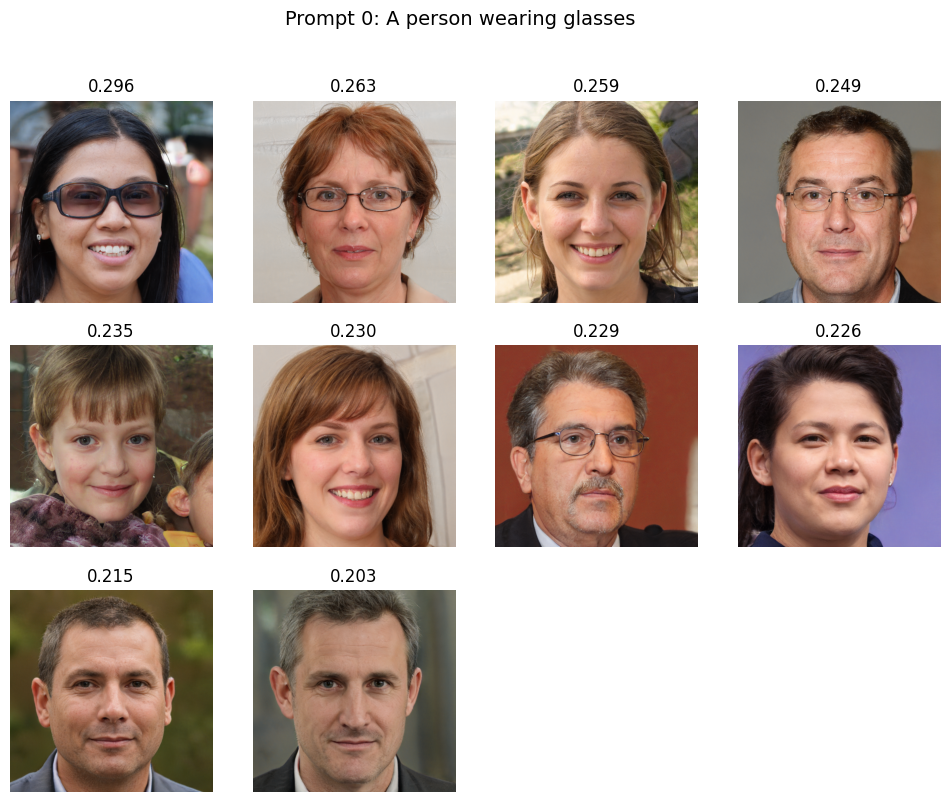

In [10]:
prompts = ["A person wearing glasses"]
sims, sorted_idx = score_and_show(imgs, prompts, clip_img_batch=10, topk=num_samples)


Select the top images and extract corresponding latent vectors:

In [12]:
# Suppose w_all is [N, 512]
top_indices = np.argsort(sims[:,0])[::-1][:top_k].copy()  # make a copy to fix negative stride

# Convert to tensor on the correct device
top_indices_tensor = torch.tensor(top_indices, device=w_all.device, dtype=torch.long)

# Safe selection using index_select
w_glasses = torch.index_select(w_all, 0, top_indices_tensor)  # [top_k, 512]


Compute the average latent vector for  *w_glasses* : 

In [16]:
w_glasses_mean = w_glasses.mean(0, keepdim=True)

Now, we need to implement the same procedure for faces without glasses, *w_no_glasses*:

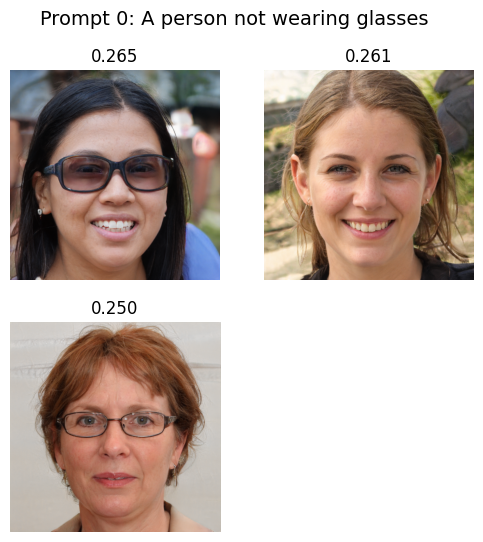

In [17]:
prompts = [
    "A person not wearing glasses"
]
sims_no_glasses, sorted_idx_no_glasses = score_and_show(imgs, prompts, clip_img_batch=16, topk=top_k)

# Top latent indices for "no glasses"
top_indices_no_glasses = np.argsort(sims_no_glasses[:,0])[::-1][:top_k]
top_indices_no_glasses_tensor = torch.tensor(top_indices_no_glasses.copy(), device=w_all.device)

# Select the latent vectors safely
w_no_glasses = torch.index_select(w_all, 0, top_indices_no_glasses_tensor)  # [top_k, 512]


w_no_glasses_mean = w_no_glasses.mean(0, keepdim=True)

w_glasses_direction = w_glasses_mean - w_no_glasses_mean

Now, our direction glasses direction is: 

In [19]:
w_glasses_direction = w_glasses_mean - w_no_glasses_mean

We can generate GAN's representation for the glasses direction as below: 

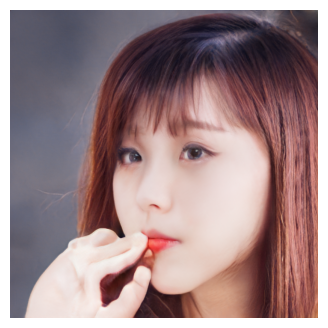

In [85]:
z_new = torch.randn([1, G.z_dim], device=device)
w_new = G.mapping(z_new, None)
w_dir_norm = w_glasses_direction / w_glasses_direction.norm()

# Add glasses
w_new_glasses = w_new + 0.5 * w_dir_norm  # alpha=2
img_new_glasses = G.synthesis(w_new_glasses)

import matplotlib.pyplot as plt
import torchvision.utils as vutils

# Rescale to [0, 1]
img_show = (img_new_glasses.clamp(-1, 1) + 1) / 2.0

# Convert to grid if you have multiple images, here only 1
grid = vutils.make_grid(img_show, nrow=1)

# Plot
plt.figure(figsize=(4,4))
plt.axis('off')
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
plt.show()